# Deep Q-Network implementation

This notebook shamelessly demands you to implement a DQN - an approximate q-learning algorithm with experience replay and target networks - and see if it works any better this way.

Based on Yandex School of Data Analysis Practical RL course.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [1]:
%pip install gymnasium
%pip install gymnasium[atari]
%pip install gymnasium[accept-rom-license]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Let's play some old videogames
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/nerd.png)

This time we're gonna apply approximate q-learning to an atari game called Breakout. It's not the hardest thing out there, but it's definitely way more complex than anything we tried before.


### Processing game image 

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top & bottom)

In [2]:
import cv2
from gymnasium.core import ObservationWrapper
from gymnasium.spaces import Box
import matplotlib.pyplot as plt

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1))

    def observation(self, img):
        """what happens to each observation"""
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # img = (img > 0.4).astype(np.float64)
        # img = img[100:-17, 8:-8]
        img = img[57:-17, 6:-6]
        img = cv2.resize(img, self.img_size)
        # img = (img > 0.4).astype(np.float64)
        img = img[..., np.newaxis]
        return img


### Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to fing optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity.

To do so, we introduce a buffer that stores 4 last images. This time everything is pre-implemented for you.

In [3]:
from gymnasium.spaces.box import Box
from gymnasium.core import Wrapper

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError('dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset()[0])
        return self.framebuffer
    
    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info, _ = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info
    
    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

In [4]:
def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


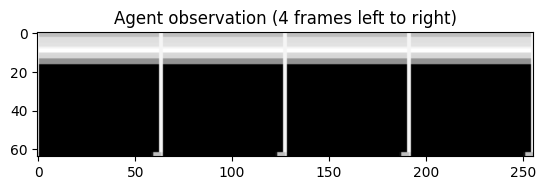

In [5]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
# plt.imshow(env.render("rgb_array"))
# plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0,2,1]).reshape([state_dim[0],-1]), 'gray');

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless you have an array of GPUs. Instead, you can use strided convolutions with a small number of features to save time and memory.

You can build any architecture you want, but for reference, here's something that will more or less work:

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/dqn_arch.png)

In [6]:
import random
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, Flatten, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import keras

class DQNAgent:
    def __init__(self, state_shape, n_actions, epsilon=0, gamma=0.99):
        """A simple DQN agent"""
        self.state_shape = state_shape
        self.n_action = n_actions
        self.epsilon = epsilon
        self.gamma = gamma
        
        self.model = self._create_network(state_shape, n_actions)
        self.target_model = self._create_network(state_shape, n_actions)
    
    def get_action(self, state, greedy=False):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        if not greedy and random.random() < self.epsilon:
            return self.get_random_action()
        else:
            return self.get_best_action(state)
    
    def get_best_action(self, state):
        qvalues = self.model.predict_on_batch(np.array([state]))[0]
        best_action = np.argmax(qvalues)
        return best_action
    
    def get_random_action(self):
        return random.randint(0, self.n_action-1)
    
    def replay(self, exp_replay, batch_size):
        states, actions, rewards, next_states, dones = exp_replay.sample(batch_size)
        
        merged = self.target_model.predict_on_batch(np.vstack([states, next_states]))
        outputs_target = merged[:batch_size]
        next_outputs_target = merged[batch_size:]
        next_outputs_model = self.model.predict_on_batch(np.array(next_states))
        
        data = []
        labels = []
        for state, action, reward, done, output_target, next_output_target, next_output_model in \
            zip(states, actions, rewards, dones, outputs_target, next_outputs_target, next_outputs_model):
            if done:
                expected_reward = reward
            else:
                index = np.argmax(next_output_target)
                expected_reward = reward + self.gamma * next_output_model[index]
                
            label = np.array(output_target)
            label[action] = expected_reward
            
            data.append(state)
            labels.append(label)
        
        data = np.array(data)
        labels = np.array(labels)
        
        self.target_model.train_on_batch(data, labels)
        
    def update_weights(self):
        """copy trained Q Network params to target Q Network"""
        self.model.set_weights(self.target_model.get_weights()) 
        
    def save(self):
        self.target_model.save_weights('breakout')
        
    def load(self):
        self.model.load_weights('breakout')
        self.target_model.load_weights('breakout')
    
    def _create_network(self, state_shape, n_actions):
        network = Sequential([
                InputLayer(state_shape),
                Conv2D(16, 3, strides=2, activation='relu'),
                Conv2D(32, 3, strides=2, activation='relu'),
                Conv2D(64, 3, strides=2, activation='relu'),
                Flatten(),
                Dense(256, activation='relu'),
                Dense(n_actions)
            ])
        network.compile(optimizer=Adam(amsgrad=True, learning_rate=0.0001), loss='mse')
        return network

2023-04-12 20:57:24.119109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
agent = DQNAgent(state_dim, n_actions, epsilon=0.5)

2023-04-12 20:57:25.551756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-12 20:57:25.625729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-12 20:57:25.625871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-12 20:57:25.626302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

Now let's try out our agent to see if it raises any errors.

In [8]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            action = agent.get_action(s, greedy)
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break
        rewards.append(reward)
    return np.mean(rewards)

In [25]:
evaluate(env, agent, n_games=1)

2023-04-12 12:55:51.914515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-04-12 12:55:52.671570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


0.0

### Experience replay
For this assignment, we provide you with experience replay buffer. If you implemented experience replay buffer in last week's assignment, you can copy-paste it here __to get 2 bonus points__.

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png)

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [9]:
import random

class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return (
            np.array(obses_t),
            np.array(actions),
            np.array(rewards),
            np.array(obses_tp1),
            np.array(dones)
        )

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [
            random.randint(0, len(self._storage) - 1)
            for _ in range(batch_size)
        ]
        return self._encode_sample(idxes)

In [27]:
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(), 1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [10]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.
    
    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"
    
    :returns: return sum of rewards over time
    """
    # initial state
    reward = 0
    s = env.framebuffer
    step = 0
    while True:
        action = agent.get_action(s)
        s_next, r, done, _ = env.step(action)
        exp_replay.add(s, action, r, s_next, done)
        s = s_next
        step += 1
        reward += r
        if done:
            env.reset()
            s = env.framebuffer
        if step >= n_steps:
            return reward
    

In [32]:
# testing your code. This may take a minute...
exp_replay = ReplayBuffer(20000)

play_and_record(agent, env, exp_replay, n_steps=10000)

# if you're using your own experience replay buffer, some of those tests may need correction. 
# just make sure you know what your code does
assert len(exp_replay) == 10000, "play_and_record should have added exactly 10000 steps, "\
                                 "but instead added %i"%len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]"%(np.mean(is_dones), len(exp_replay))
    
for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_dim
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s"%str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s"%str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s"%str(is_done_batch.shape)
    assert [int(i) in (0,1) for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a <= n_actions for a in act_batch], "actions should be within [0, n_actions]"
    
print("Well done!")

Well done!


### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png)



### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Take q-values for actions agent just took

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

### Main loop

It's time to put everything together and see if it learns anything.

In [11]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
mean_rw_history = []

In [13]:
env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

exp_replay = ReplayBuffer(10**5)
agent = DQNAgent(state_dim, n_actions, epsilon=0.5)
play_and_record(agent, env, exp_replay, 10000)

In [14]:
agent = DQNAgent(state_dim, n_actions, epsilon=0.21)
agent.load()

In [15]:
import pickle

with open('exp_replay.pickle', 'rb') as handle:
    exp_replay = pickle.load(handle)

buffer size = 100000, epsilon = 0.02000


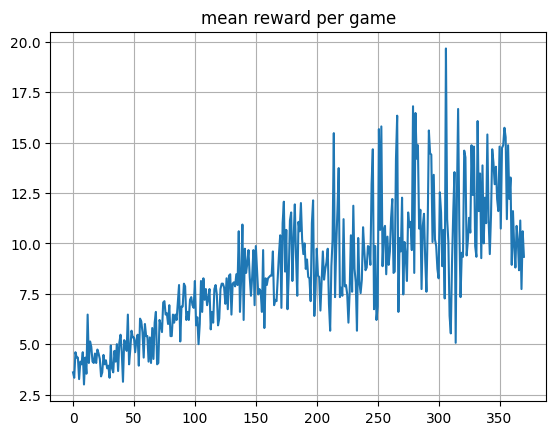

 16%|█▌        | 15639/100000 [1:21:42<7:20:45,  3.19it/s]  


In [24]:
for i in trange(10**5):
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train
    agent.replay(exp_replay, 512)
    
    if i % 500 == 0:
        agent.update_weights()
        
    if i % 500 == 0:
        agent.epsilon = max(agent.epsilon * 0.99, 0.02)
    
    if i % 500 == 0:
        mean_rw_history.append(evaluate(make_env(), agent, n_games=15, greedy=False))
        agent.save()
        
    if i % 500 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()
        plt.show()

In [18]:
import pickle

with open('exp_replay.pickle', 'wb') as handle:
    pickle.dump(exp_replay, handle)
    
with open('mean_rw_history.pickle', 'wb') as handle:
    pickle.dump(mean_rw_history, handle)

In [31]:
assert np.mean(mean_rw_history[:-20][-10:]) > 10.
print("That's good enough for tutorial.")

That's good enough for tutorial.


__ How to interpret plots: __


This aint no supervised learning so don't expect anything to improve monotonously. 
* __ TD loss __ is the MSE between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or stayng at exactly zero before agent has perfect performance.
* __ mean reward__ is the expected sum of r(s,a) agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...). 
 * In basic q-learning implementation it takes 5-10k steps to "warm up" agent before it starts to get better.
* __ buffer size__ - this one is simple. It should go up and cap at max size.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - __ it means you need to increase epsilon__. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.

At first your agent will lose quickly. Then it will learn to suck less and at least hit the ball a few times before it loses. Finally it will learn to actually score points.

__Training will take time.__ A lot of it actually. An optimistic estimate is to say it's gonna start winning (average reward > 10) after 10k steps. 

But hey, look on the bright side of things:

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/training.png)